## Exploration of PCEN parameters

## First, let's setup needed packages and parameter used throughout the notebook

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import src.conf as conf
import math
import librosa.display
from scipy.stats import norm
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
fmax = 8000  # maximum frequency
window_size = 1024 # fft window size
overlap = 0.5 
hop_length = int(window_size * (1 - overlap))
xs_norm = np.arange(-3, 3, 0.001) # data for an ideal Gaussian curve for comparison
ys_norm = norm.pdf(xs_norm, 0, 1)

# PCEN 
PCEN parameters need to be adjusted for each component: temporal integration, gain control, and dynamic compression. 

The defaults in the python librosa implementation are the same as those in the original paper [1] which are not
suited for underwater acoustic sound (need further details here on what they were set for). 

# PCEN Parameters T and s
[2] Recommends that "time constant T should be not longer than the time taken by a frequency-modulated foreground event
to move from one subband f to another, adjacent subband".
 
[3] Recommends for bioacoustic networks where a faster modulation of the foreground occurs, a lower T is needed. 
In that paper they use T=60ms for bird calls. 

We know that whales call mean frequency and shape of the fundamental frequency changes, but do they
frequency modulate their sound, and if so how fast?  Let's assume for this exploration that it's 10x slower 
than bird sounds or 0.6 seconds.

The choice for T sets the value of K according to:
```bash
K = T * c * N / (mel(fmax) - mel(fmin))
``` 
where
* K = becomes some constant, depends on reverberation properties of the environment; 1 in dry environments and 10 in highly reverberant ones.
* T = temporal integration 
* c = typical chirp rate of the event of interest, where chirp is defined as
```bash
chirp deviation (change in frequency either up or down in mel frequency) / chirp pulse width 
```
* N = mel frequency of N bands

Important point - any change in the resolution of the time-frequency representation should be reflected in an update of T.
So this means any changes to FFT window size and overlap, e.g. requires a change to the PCEN parameters. 

Assuming T = 0.6 seconds
```
T = 0.6
```
and the typical chirp rate is 100 Hz change over 1 second
```
c = 100
```
K = 5 and s ~= 0.0619 as computed below:

In [2]:
N = 128 
T = 0.6
sample_rate = 16000
c_per_sec = 100 #  Hz/second 
c = c_per_sec / librosa.core.hz_to_mel(1)
K = T * c * N / (librosa.core.hz_to_mel(0) - librosa.core.hz_to_mel(fmax))
sec_per_slice = ((window_size / sample_rate) * (1-overlap))
# τ is the discretization time step (“hop size”) in seconds
hop_step = hop_length * sec_per_slice
tau = 1/hop_step
b = math.cos((2*math.pi*tau)/T)
s = math.sqrt(1 - b)*(math.sqrt(3 - b) - math.sqrt(1 - b))
print(f's={s} K={K} T={T} seconds {N} mels between 0 and {fmax} Hz')

s=0.4612114212296168 K=-11316.007346999482 T=0.6 seconds 128 mels between 0 and 8000 Hz


# PCEN Parameters ε and α (gain)
* α = 1 leads to an optimal cancellation of stationary background but can skew the distribution of magnitudes towards the right
* α < 1 reduces skewness and brings the background closer to AWGN
* ε no effect but should be < 1.0

Here, let's set α and ε to the same as the bird paper [3].

In [3]:
alpha = 0.98
epsilon = 10e-6

# PCEN Parameters δ (bias) and r (power)
* δ → +∞ in highly noisy applications  2 is the default in [1]
* δ → 1 reduces variance in the loudness of foreground events 
* recommend r = 0.5 for indoor applications (d ∼ 10 m) 
* recommend r = 0.25 for outdoor applications (d ∼ 100 m)

Here, let's set α and ε to the same as the bird paper [3].

In [4]:
delta = 10
r = 0.25

In [5]:
def display_spec_mag(pcen_s_array, title_append):
    '''
    Displays spectrogram and magnitude distribution grid of pcen arrays
    :param pcen_s_array:  numpy array of PCEN computed mel spectrogram array
    :param title_append:  title to append to the spectrogram
    :return: 
    '''
    fig = plt.figure(constrained_layout=True,  figsize=(8, 2))
    widths = [8, 2]
    heights = [1]
    axes = []
    spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths, height_ratios=heights )
    for col in range(2):
        axes.append(fig.add_subplot(spec[0, col]))
    def normalize(a):
        return (a - a.mean(axis=0)) / a.std(axis=0)
       
    librosa.display.specshow(pcen_s_array, x_axis='time', y_axis='mel', ax=axes[0], cmap='Blues', sr=sample_rate)
    axes[0].set_title(f'Per-channel energy normalization  {title_append}')
    sns.distplot(normalize(pcen_s_array), ax=axes[1])
    axes[1].set_title('magnitude distribution');axes[1].set_xlim(-4, 4); axes[1].set_ylim(0, 0.6)
    axes[1].plot(xs_norm, ys_norm, 'r--', label="Gaussian")

# Explore role each parameter plays
### Load two 5 minutes segments from a wav file representing two different background levels

In [6]:
import os
import src.conf as conf
wav_file=os.path.join(conf.wav_path, conf.target_file_test + '.wav')
samples_A, _ = librosa.load(wav_file, sr=sample_rate, offset=6000, duration=300)
samples_B, _ = librosa.load(wav_file, sr=sample_rate, offset=7200, duration=300)

## Assuming all other parameters remain constant, modify the α (gain) for each sample

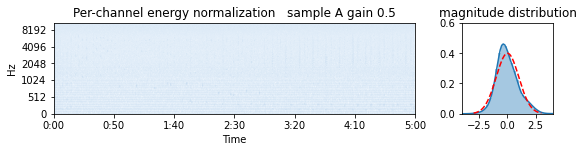

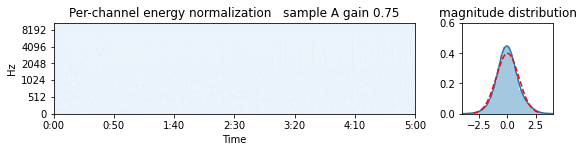

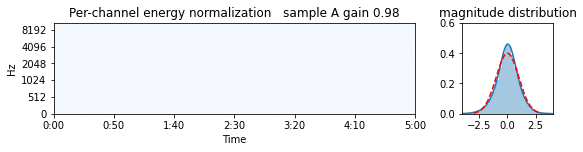

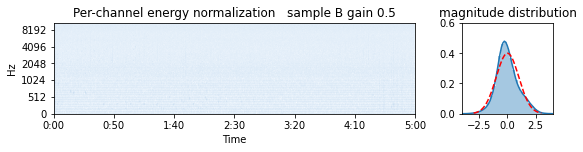

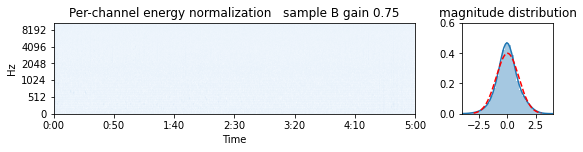

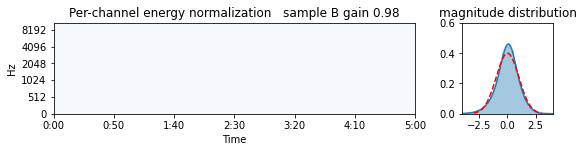

In [7]:
gain = [0.5, 0.75, 0.98]
d = dict({'A': samples_A, 'B': samples_B})
for i in d:
    S = librosa.feature.melspectrogram(d[i], sr=sample_rate, power=.0625, fmax=fmax, n_fft=window_size, hop_length=hop_length)
    for g in gain:
        pcen_S = librosa.pcen(S* (2**31), hop_length=hop_length, gain=g, bias=delta, power=r, time_constant=T, eps=epsilon)
        display_spec_mag(pcen_S, f' sample {i} gain {g}') 

## Assuming all other parameters remain constant, modify the r (power) for each sample.
For outdoor applications r = 0.25 for distances ~ 100m. Assuming sound source is > 100m,
 let's see how this changes with smaller values

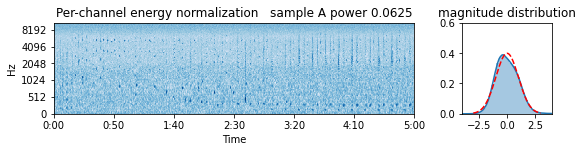

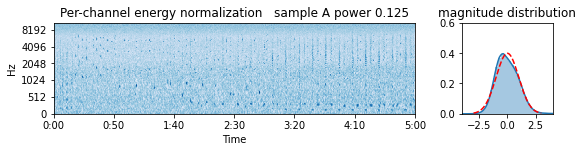

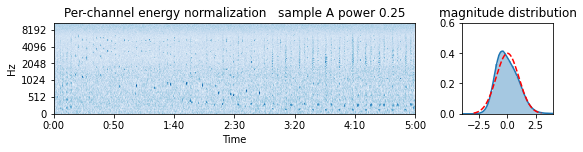

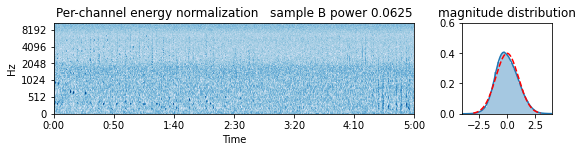

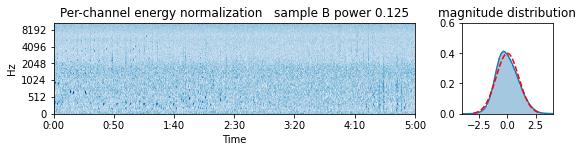

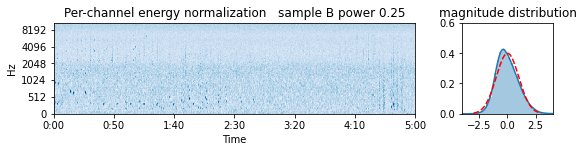

In [8]:
power = [0.0625, 0.125, 0.25]
d = dict({'A': samples_A, 'B': samples_B})
for i in d:
    S = librosa.feature.melspectrogram(d[i], sr=sample_rate, power=1, fmax=fmax, n_fft=window_size, hop_length=hop_length)
    for p in power:
        pcen_S = librosa.pcen(S* (2**31), hop_length=hop_length, gain=0.5, bias=delta, power=p, time_constant=T, eps=epsilon)
        display_spec_mag(pcen_S, f' sample {i} power {p}') 
        

## Assuming all other parameters remain constant, modify the time constant T or each sample.

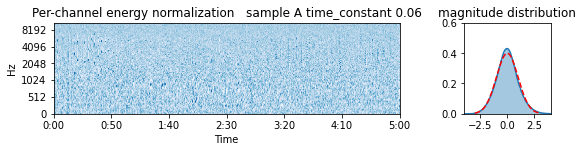

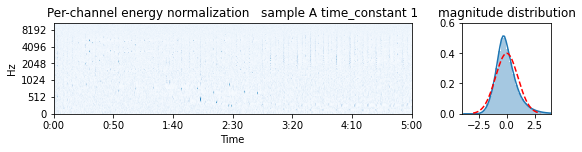

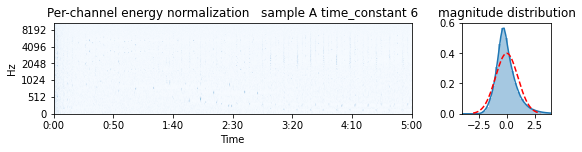

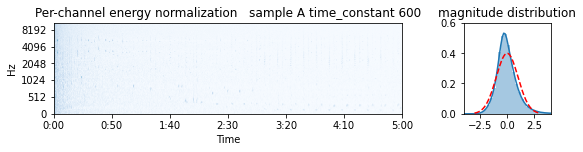

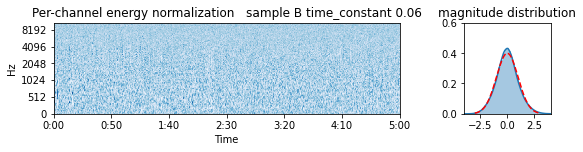

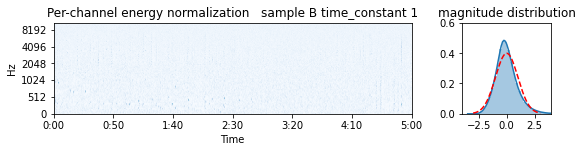

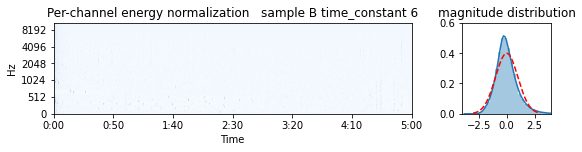

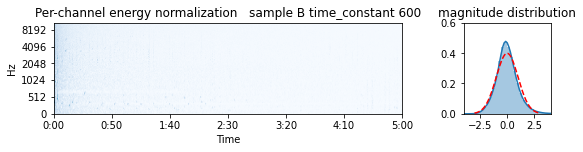

In [9]:
time_constant = [0.060, 1, 6, 600]
d = dict({'A': samples_A, 'B': samples_B})
for i in d:
    S = librosa.feature.melspectrogram(d[i], sr=sample_rate, power=1, fmax=fmax, n_fft=window_size, hop_length=hop_length)
    for t in time_constant:
        pcen_S = librosa.pcen(S* (2**31), hop_length=hop_length, gain=alpha, bias=delta, power=r, time_constant=t, eps=epsilon)
        display_spec_mag(pcen_S, f' sample {i} time_constant {t}') 

## Assuming all other parameters remain constant, modify the bias of each sample.

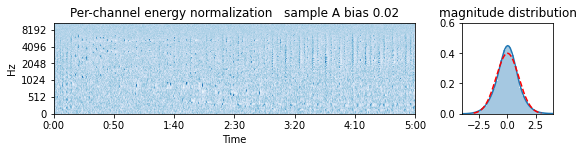

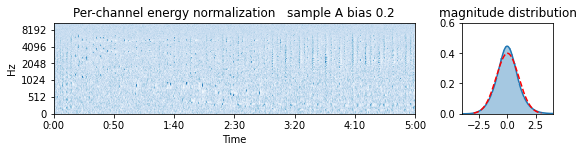

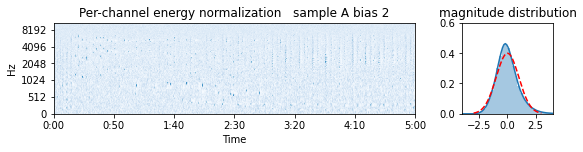

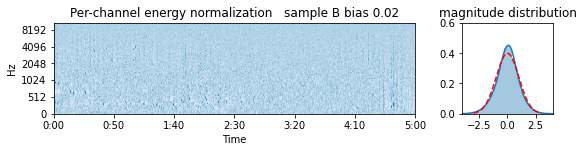

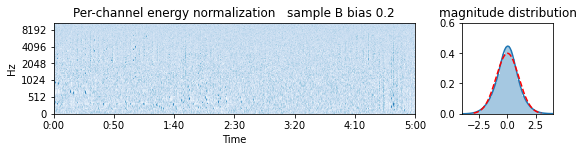

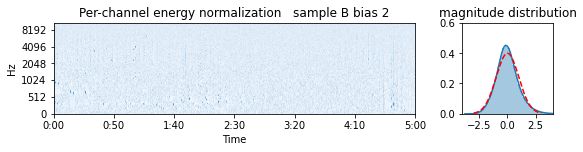

In [10]:
biases = [0.02, 0.2, 2]
d = dict({'A': samples_A, 'B': samples_B})
for i in d:
    S = librosa.feature.melspectrogram(d[i], sr=sample_rate, power=1, fmax=fmax, n_fft=window_size, hop_length=hop_length)
    for b in biases:
        pcen_S = librosa.pcen(S* (2**31), hop_length=hop_length, gain=alpha, bias=b, power=r, time_constant=T, eps=epsilon)
        display_spec_mag(pcen_S, f' sample {i} bias {b}') 
            

## References
[1]	Wang, Y., Getreuer, P., Hughes, T., Lyon, R. F., & Saurous, R. A. (2017, March). Trainable frontend for robust and far-field keyword spotting. In Acoustics, Speech and Signal Processing (ICASSP), 2017 IEEE International Conference on (pp. 5670-5674). IEEE.

[[2]](http://www.justinsalamon.com/uploads/4/3/9/4/4394963/lostanlen_pcen_spl2018.pdf) Lostanlen, V., Salamon, J., McFee, B., Cartwright, M., Farnsworth, A., Kelling, S., and Bello, J. P. Per-Channel Energy Normalization: Why and How. IEEE Signal Processing Letters, 26(1), 39-43.

[[3]](https://arxiv.org/pdf/1905.08352v2.pdf) Lostanlen, Vincent et al. “Robust Sound Event Detection in Bioacoustic Sensor Networks.” Ed. Ian McLoughlin. PLOS ONE 14.10 (2019): e0214168. Crossref. Web.